In [1]:
import pandas as pd
import numpy as np
from info_gain import info_gain
import json

In [63]:
df = pd.read_csv('data/breast_cancer_transcript_expression_with_label.csv')
df = df.set_index('Unnamed: 0').T

In [31]:
df.head()

Unnamed: 0,ENST00000548312.5,ENST00000338863.11,ENST00000570899.1,ENST00000556831.5,ENST00000625998.2,ENST00000383738.6,ENST00000012134.6,ENST00000403263.5,ENST00000627368.2,ENST00000614486.4,...,ENST00000396028.6,ENST00000380620.8,ENST00000548698.5,ENST00000542429.2,ENST00000422233.5,ENST00000463473.2,ENST00000380293.3,ENST00000288710.6,ENST00000250055.2,ER status
TCGA-BH-A18U-01,0.0,18.300627,0.34999,0.400007,1.319972,0.049999,1.889935,1.70002,0.0,0.180005,...,0.019999518,14.75981014,0,0,0,0,0,0.149997859,0.200004541,Positive
TCGA-D8-A27K-01,0.219997,23.09066,0.209998,0.459988,3.009911,0.03,3.62003,4.349858,0.0,0.849982,...,0,2.269956387,0,0,0,0.080001925,0,1.909963205,0.479997066,Positive
TCGA-BH-A0B5-01,0.089999,21.610091,0.0,0.869973,4.230004,0.0,1.60003,3.800055,0.0,0.709989,...,0.120001765,6.360204645,0,0,0,0.049998549,0,0.029999742,0.329999284,Positive
TCGA-BH-A18K-01,0.03,14.93995,0.250007,1.059982,0.969971,0.01,2.160001,1.540035,0.0,0.159996,...,0,3.930009908,0,0,0,0,0,0.189994103,2.689920931,Positive
TCGA-C8-A12N-01,0.189994,15.650185,0.239999,0.640002,3.990138,0.0,4.239987,2.459924,0.0,0.949989,...,0,1.199969906,0,0,0,0,0,0.430012017,0.230005643,Positive


In [32]:
r, c = df.shape
array = df.values
# Y = df.iloc[:,0]
# X = df.iloc[:,1:c]
X = df.iloc[:,0:(c-1)]
Y = df.iloc[:,(c-1)]
X.shape, Y.shape

((1048, 93650), (1048,))

In [4]:
# probs = df.value_counts(normalize=True)

In [5]:
# probs.head()

In [6]:
def compute_impurity(feature, impurity_criterion):
    """
    This function calculates impurity of a feature.
    Supported impurity criteria: 'entropy', 'gini'
    input: feature (this needs to be a Pandas series)
    output: feature impurity
    """
    probs = feature.value_counts(normalize=True)
    
    if impurity_criterion == 'entropy':
        impurity = -1 * np.sum(np.log2(probs) * probs)
    elif impurity_criterion == 'gini':
        impurity = 1 - np.sum(np.square(probs))
    else:
        raise ValueError('Unknown impurity criterion')
        
    return(round(impurity, 3))

def comp_feature_information_gain(df, target, descriptive_feature, split_criterion, info_gain):
    """
    This function calculates information gain for splitting on 
    a particular descriptive feature for a given dataset
    and a given impurity criteria.
    Supported split criterion: 'entropy', 'gini'
    """
            
    target_entropy = compute_impurity(df[target], split_criterion)

    # we define two lists below:
    # entropy_list to store the entropy of each partition
    # weight_list to store the relative number of observations in each partition
    entropy_list = list()
    weight_list = list()
    
    # loop over each level of the descriptive feature
    # to partition the dataset with respect to that level
    # and compute the entropy and the weight of the level's partition
    for level in df[descriptive_feature].unique():
        df_feature_level = df[df[descriptive_feature] == level]
        entropy_level = compute_impurity(df_feature_level[target], split_criterion)
        entropy_list.append(round(entropy_level, 3))
        weight_level = len(df_feature_level) / len(df)
        weight_list.append(round(weight_level, 3))

    feature_remaining_impurity = np.sum(np.array(entropy_list) * np.array(weight_list))
    
    information_gain = target_entropy - feature_remaining_impurity
    
    info_gain[descriptive_feature] = information_gain
    # return(information_gain)

In [7]:
x = df.drop(columns='ER status').columns

In [10]:
split_criterion = 'gini'
info_gain_dict = {}
for i, feature in enumerate(x):
    print(f'{i}/{df.shape[1] - 1}', end='\r')
    info_gain_dict[feature] = info_gain.info_gain(list(df['ER status']), list(df[feature]))
    # info_gain[feature] = info_gain(df['ER status'], df[feature])
    # info_gain[feature] = comp_feature_information_gain(df, 'ER status', feature, split_criterion, info_gain)

In [ ]:
import json 
json.dump(info_gain_dict, open("IGbreastcancer.txt",'w'))

In [6]:
io = open("IGbreastcancer.txt","r")
x = json.load(io)

In [11]:
import operator
sorted_x = dict(sorted(x.items(), key=operator.itemgetter(1),reverse=True))

In [14]:
sorted_keys = []
x_keys = x.keys()
sorted_x_keys = sorted_x.keys()
for i, key in enumerate(sorted_x_keys):
    print(f'{i}/{len(sorted_x_keys)}', end='\r')
    sorted_keys.append(list(x_keys).index(key))


In [19]:
sorted_keys[-50]

89376

In [23]:
list(x_keys)[89376]

'ENST00000565287.5'

In [24]:
x[list(x_keys)[89376]]

0.0

In [25]:
json.dump(sorted_keys, open("IGorderbreastcancer.txt",'w'))

In [ ]:
io = open("IGbreastcancer.txt","r")
x = json.load(io)

In [28]:
io = open("IGorderbreastcancer.txt","r")
ordered_x = json.load(io)
ordered_x

[18443,
 346,
 23214,
 33846,
 39174,
 70977,
 78767,
 1937,
 2057,
 3513,
 4040,
 7791,
 8886,
 10986,
 17818,
 26592,
 26760,
 29703,
 40387,
 42621,
 54763,
 55514,
 56325,
 61052,
 66064,
 68018,
 68504,
 68750,
 73596,
 76200,
 88021,
 91437,
 44330,
 902,
 4418,
 4676,
 9816,
 10196,
 12650,
 13072,
 15489,
 19928,
 23916,
 24851,
 30469,
 37368,
 38455,
 38854,
 39809,
 45123,
 48341,
 51831,
 51996,
 53518,
 54365,
 55343,
 59518,
 59647,
 69603,
 69606,
 71018,
 71213,
 71280,
 72298,
 76274,
 80546,
 82177,
 83426,
 2994,
 85885,
 1560,
 1633,
 5100,
 5191,
 6383,
 10237,
 11063,
 11491,
 16308,
 17913,
 18133,
 18866,
 19394,
 21902,
 26122,
 30339,
 35036,
 35656,
 44367,
 44598,
 45573,
 48904,
 54006,
 54917,
 55984,
 56104,
 56910,
 66103,
 68670,
 70632,
 71173,
 71508,
 72465,
 72931,
 74101,
 76097,
 78769,
 79512,
 86353,
 86602,
 86919,
 88464,
 89625,
 89688,
 1574,
 24140,
 55091,
 59814,
 66827,
 71731,
 76585,
 82944,
 91899,
 12521,
 85418,
 1065,
 4467,
 5495,

In [117]:
io = open("IGbreastcancer.txt","r")
x = json.load(io)

In [118]:
x_mean = np.mean(list(x.values()))
x_std = np.std(list(x.values()))
zero_ig = {}
for key, value in x.items():
    if value < x_mean:
        zero_ig[key] = x[key]

In [119]:
print(len(zero_ig))
len(x) - len(zero_ig)

60496


33154

In [120]:
x_abovemean = x
for key, value in zero_ig.items():
    x_abovemean.pop(key)

In [121]:
len(x_abovemean)

33154

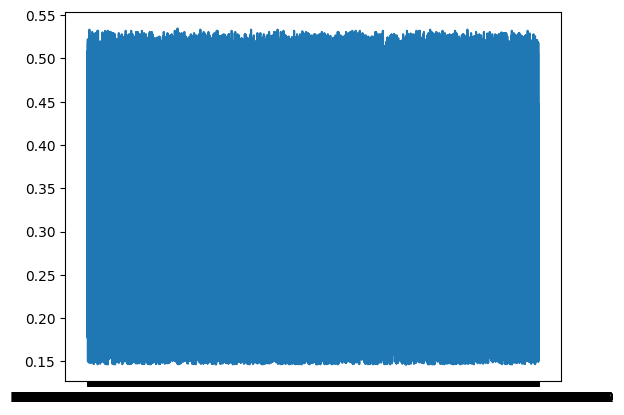

In [34]:
import matplotlib.pyplot as plt

lists = x_abovemean.items() # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

In [36]:
%pip install yellowbrick matplotlib_venn kmapper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 1.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 1.5 MB/s eta 0:00:00a 0:00:01
  Using cached MarkupSafe-2.1.1-cp39-cp39-macosx_10_9_x86_64.whl (13 kB)
  Created wheel for matplotlib_venn: filename=matplotlib_venn-0.11.7-py3-none-any.whl size=32155 sha256=c519a04fa15ddd65eea4dc8773c25d97eacd5bc7c3cb62881aa735486b02077b
  Stored in directory: /Users/prudvikamtam/Library/Caches/pip/wheels/32/41/5f/d0f29cd092d042d8e8a87d7bbe42193166aa555ff38b377343
Successfully built matplotlib_venn

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [37]:
#Basic libraries
import numpy as np
import pandas as pd
from scipy import stats

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import yellowbrick as yb
from matplotlib.colors import ListedColormap
from yellowbrick.classifier import ROCAUC
from matplotlib_venn import venn3
import matplotlib.patches as mpatches

# Statistics, EDA, metrics libraries
from scipy.stats import normaltest, skew
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, accuracy_score, f1_score
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.metrics import classification_report, confusion_matrix
from scipy.special import boxcox, inv_boxcox

# Modeling libraries
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, cross_val_predict,  KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from scipy.stats import zscore
from itertools import combinations
# from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import IsolationForest
import kmapper as km
from sklearn.cluster import KMeans


from IPython.display import set_matplotlib_formats 
plt.style.use('ggplot')
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")


# Pallets used for visualizations
color= "Spectral"
color_plt = ListedColormap(sns.color_palette(color).as_hex())
color_hist = 'teal'
two_colors = [ sns.color_palette(color)[0], sns.color_palette(color)[5]]
three_colors = [ sns.color_palette(color)[5],sns.color_palette(color)[2], sns.color_palette(color)[0]]

In [70]:
# a function that takes a dataframe and transforms it into a standard form after dropping nun_numirical columns
def to_standard (df):
    
    num_df = df[df.select_dtypes(exclude = np.number).columns.tolist()]
    
    ss = StandardScaler()
    std = ss.fit_transform(num_df)
    
    std_df = pd.DataFrame(std, index = num_df.index, columns = num_df.columns)
    return std_df

In [75]:
df.head()

Unnamed: 0,ENST00000548312.5,ENST00000338863.11,ENST00000570899.1,ENST00000556831.5,ENST00000625998.2,ENST00000383738.6,ENST00000012134.6,ENST00000403263.5,ENST00000627368.2,ENST00000614486.4,...,ENST00000396028.6,ENST00000380620.8,ENST00000548698.5,ENST00000542429.2,ENST00000422233.5,ENST00000463473.2,ENST00000380293.3,ENST00000288710.6,ENST00000250055.2,ER status
TCGA-BH-A18U-01,0.0,18.300627,0.34999,0.400007,1.319972,0.049999,1.889935,1.70002,0.0,0.180005,...,0.019999518,14.75981014,0,0,0,0,0,0.149997859,0.200004541,Positive
TCGA-D8-A27K-01,0.219997,23.09066,0.209998,0.459988,3.009911,0.03,3.62003,4.349858,0.0,0.849982,...,0,2.269956387,0,0,0,0.080001925,0,1.909963205,0.479997066,Positive
TCGA-BH-A0B5-01,0.089999,21.610091,0.0,0.869973,4.230004,0.0,1.60003,3.800055,0.0,0.709989,...,0.120001765,6.360204645,0,0,0,0.049998549,0,0.029999742,0.329999284,Positive
TCGA-BH-A18K-01,0.03,14.93995,0.250007,1.059982,0.969971,0.01,2.160001,1.540035,0.0,0.159996,...,0,3.930009908,0,0,0,0,0,0.189994103,2.689920931,Positive
TCGA-C8-A12N-01,0.189994,15.650185,0.239999,0.640002,3.990138,0.0,4.239987,2.459924,0.0,0.949989,...,0,1.199969906,0,0,0,0,0,0.430012017,0.230005643,Positive


In [ ]:
df_dict = df.to_dict()

In [ ]:
df_dict.pop(list(df_dict.keys())[-1])

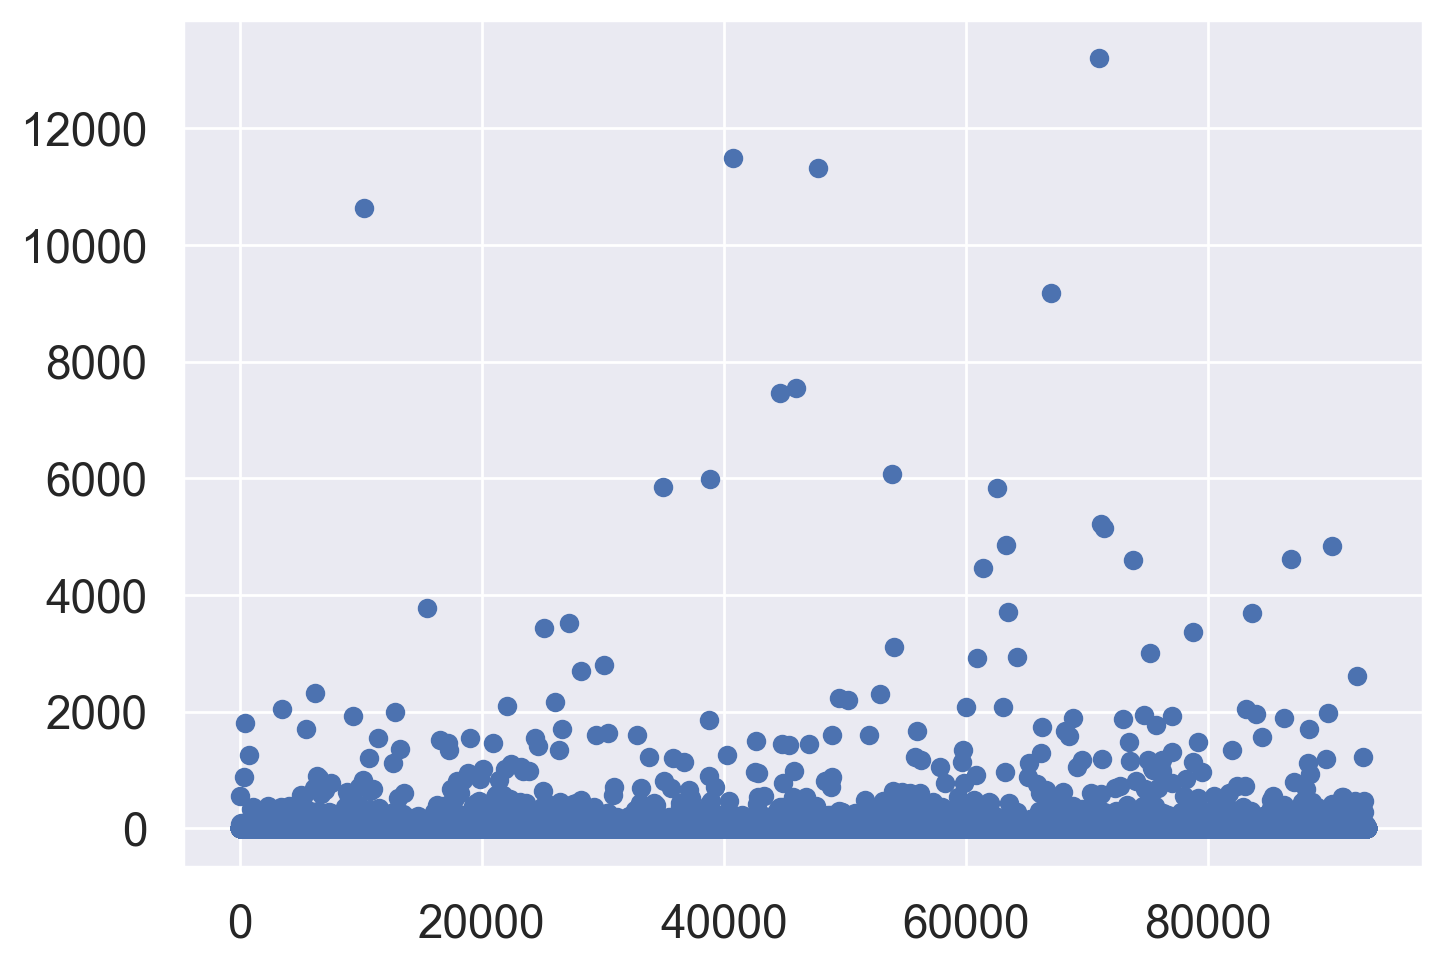

In [109]:
y_values_pos = []
y_values_neg = []
df_len = len(df_dict)
for i, (key, value) in enumerate(df_dict.items(), start=1):
    # print(type(np.std(list(value.values()))))
    # print(key, np.std(value.values()))
    # break
    try:
        std = np.std(list(value.values()))
        print(f'{i}/{df_len} = {std}', end='\r')
        # if std > 100:
        #     continue
        y_values.append(std)
    except:
        continue
# df.plot.scatter(x = 'Name', y = np.std(value), s = 50)
plt.scatter(range(len(y_values)), y_values)
plt.show()

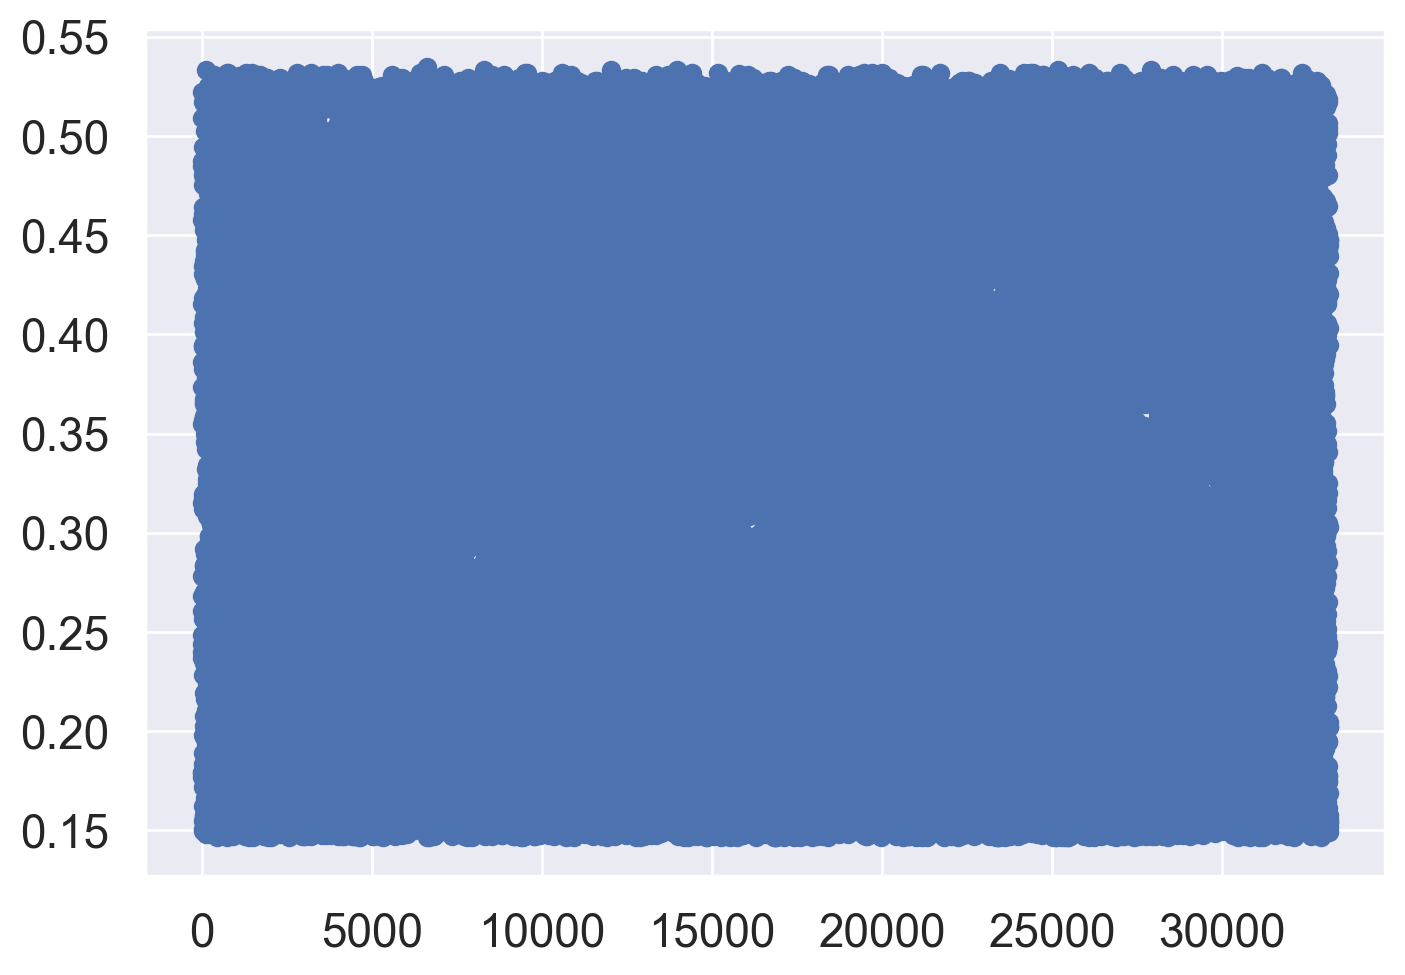

In [108]:

plt.scatter(range(len(x)), x.values())
plt.show()


ValueError: Could not interpret input 'variable'

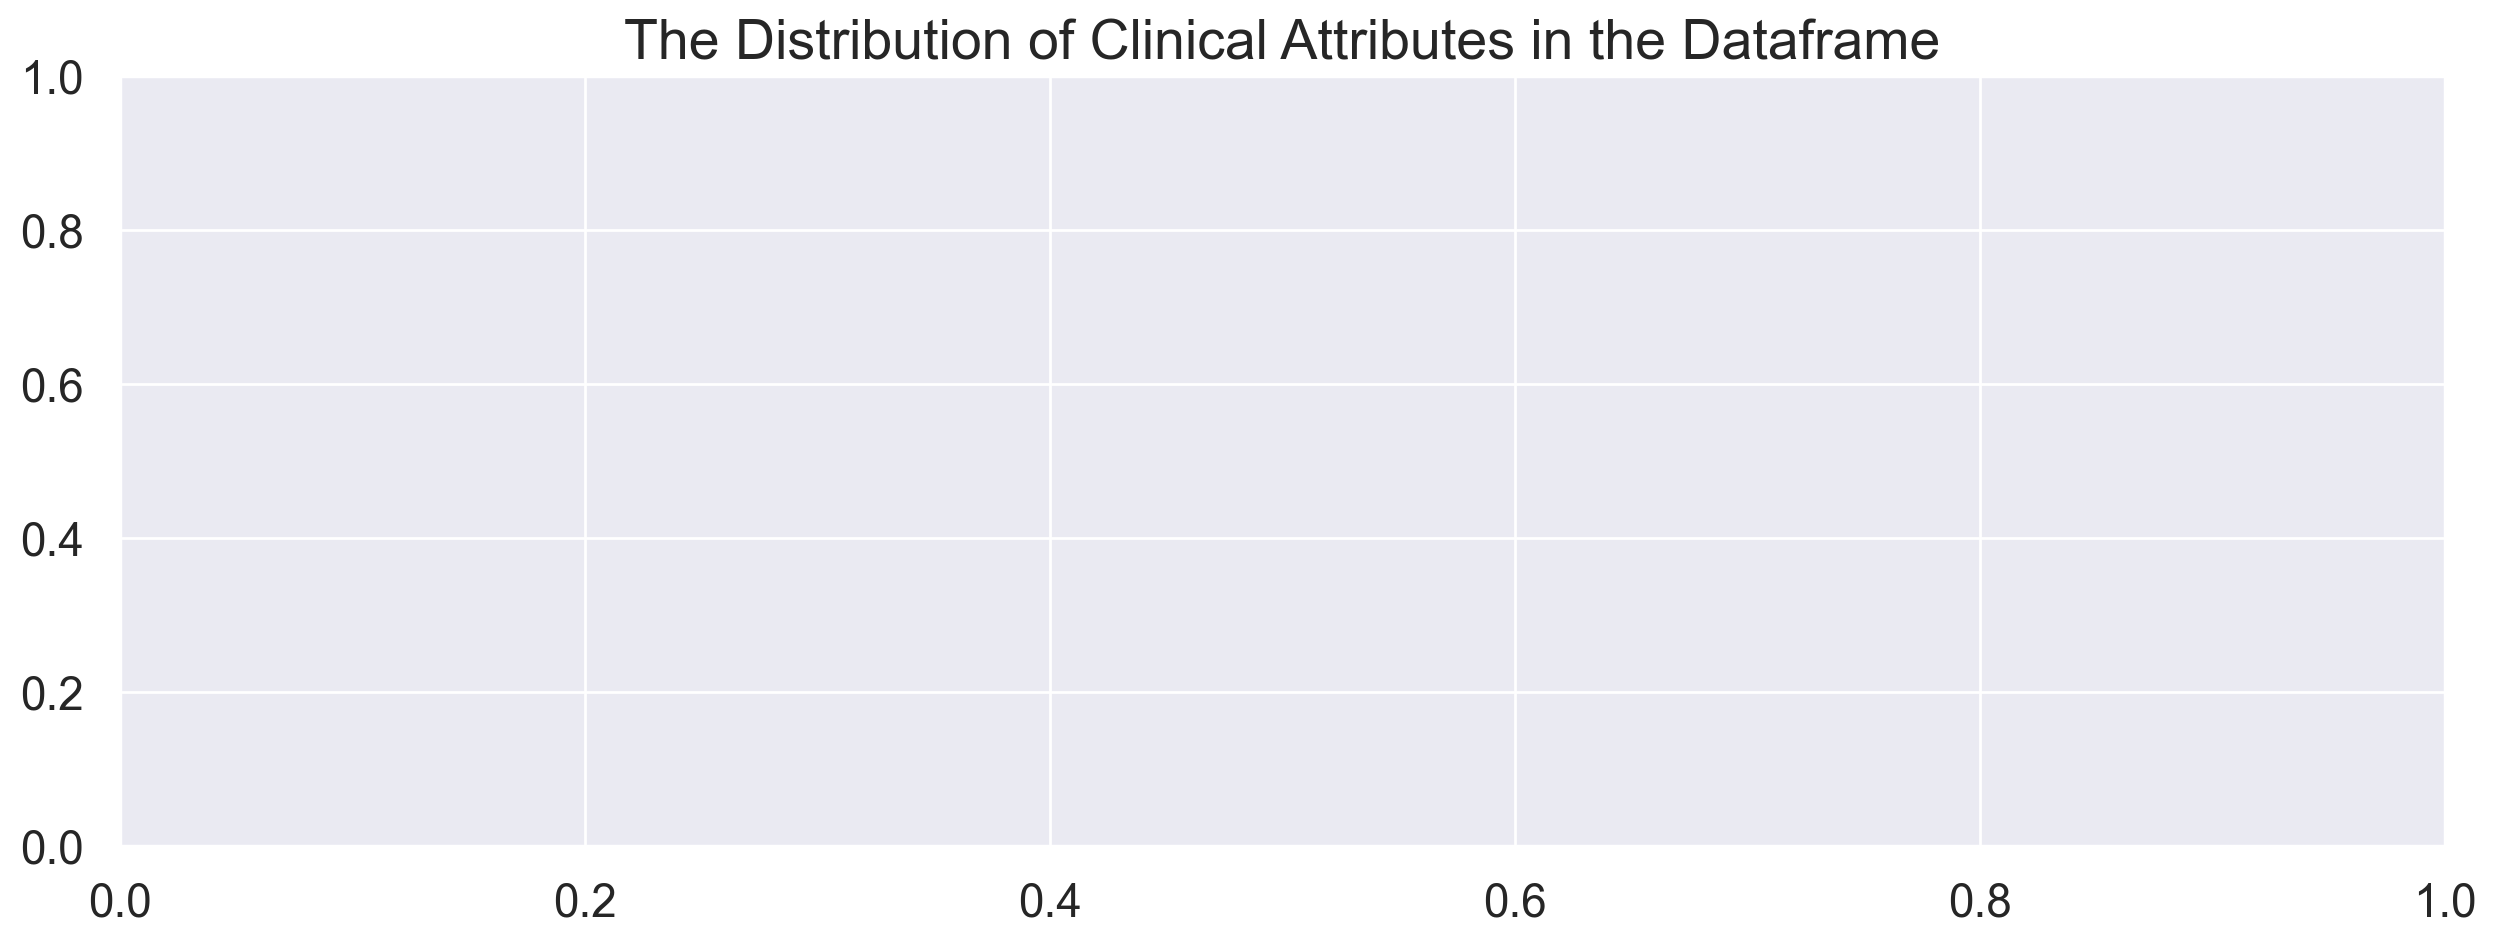

In [73]:
# print(x_abovemean)
x_abovemean = pd.DataFrame(x_abovemean.items(), columns=['Gene', 'IG'])
# x_abovemean.head()
ax, fig = plt.subplots(1, 1, figsize = (15, 5))
plt.title('The Distribution of Clinical Attributes in the Dataframe', fontsize = 20) #Change please
print('='*15)
# print(type(pd.melt(to_standard(x_abovemean))))
sns.boxplot(y = "variable", x = "value", data = pd.melt(to_standard(df.iloc[:,0:-1])), palette = 'Spectral')
plt.xlabel('Range after Standarization', size = 16)
plt.ylabel('Attribue', size = 16)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

In [122]:
x_abovemean

{'ENST00000338863.11': 0.4576529198251573,
 'ENST00000625998.2': 0.2604618167289503,
 'ENST00000012134.6': 0.2680199008735321,
 'ENST00000403263.5': 0.24404073380695007,
 'ENST00000449352.6': 0.3548883878924698,
 'ENST00000233092.10': 0.17876125627883538,
 'ENST00000486593.5': 0.2783589989348912,
 'ENST00000320152.10': 0.3735059935083156,
 'ENST00000633730.1': 0.17951588329356644,
 'ENST00000366544.5': 0.2482870626739752,
 'ENST00000541547.5': 0.3150380403193268,
 'ENST00000261037.7': 0.48495829721686523,
 'ENST00000540112.1': 0.385871626274755,
 'ENST00000240306.4': 0.17689088235287237,
 'ENST00000543697.5': 0.41532481292407,
 'ENST00000564831.5': 0.23661954271636998,
 'ENST00000299957.10': 0.48760389714266655,
 'ENST00000295962.8': 0.23995227999644497,
 'ENST00000508493.1': 0.522171743954967,
 'ENST00000572954.1': 0.5089437443259605,
 'ENST00000614488.4': 0.19828259330420056,
 'ENST00000457358.6': 0.31930423635211985,
 'ENST00000612473.1': 0.4754970533738946,
 'ENST00000585333.1': 0.